# Lab6 (Teacher version): configuration model

We can use the following libraries.

In [7]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import copy
print(sys.version)

3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]


## Exercise 0: preliminaries 

In this prectical work, we use the graph http://lioneltabourier.fr/documents/inet.txt. It is an undirected map of a subpart of the Internet.

Load it in memory as a dictionary of lists (as usual) and make the standard measurements:
* compute its number of nodes and edges
* plot its degree distribution
* compute its number of triangles
* compute a lower bound for its diameter

We indicate here the number of nodes, links and triangles of this network:
* 9740 nodes 
* 35567 edges
* 206909 triangles

In [74]:
def remove_loop_dupes(graph):
    for node in graph:
        graph[node] = list(dict.fromkeys(graph[node]))
        try:
            graph[node].remove(node)
        except ValueError:
            pass

def graph_from_file(file_name):
    graph = {}
    with open(file_name, "r") as graph_file:
        for line in graph_file:
            try:
                node1, node2 = [int(node) for node in line.split()]
                if node1 not in graph:
                    graph[node1] = []
                graph[node1].append(node2)
                if node2 not in graph:
                    graph[node2]= []
                graph[node2].append(node1)
            except:
                pass
    remove_loop_dupes(graph)
    return graph


def graph_to_file(graph, file_name):
    with open(file_name, "w") as graph_file:
        for node1 in graph:
            for node2 in graph[node1]:
                graph_file.write("{} {}\n".format(node1, node2))
def count_links(graph):
    link_count = 0
    for node in graph:
        link_count += len(graph[node])
    return link_count // 2
def compute_degree_dist(graph):
    degree_dist = {}
    for node in graph:
        degree = len(graph[node])
        if degree not in degree_dist:
            degree_dist[degree] = 0
        degree_dist[degree] += 1
    return degree_dist

def bfs(graph, node_start):
    queue = [node_start]
    marked = [node_start]
    while queue:
        node1 = queue.pop(0)
        for node2 in graph[node1]:
            if node2 not in marked:
                queue.append(node2)
                marked.append(node2)
    return marked

def compute_size_lcc(graph):
    nodes_cc_index = {}
    cc_index = 0
    cc_sizes = []
    for node in graph:
        nodes_cc_index[node] = -1
    for node in graph:
        if nodes_cc_index[node] == -1:
            cc = bfs(graph, node)
            cc_sizes.append(len(cc))
            for node_marked in cc:
                nodes_cc_index[node_marked] = cc_index
            cc_index += 1
    return max(cc_sizes)

def compute_distance(graph, node_start):
    queue = [node_start]
    distances = {}
    for node in graph:
        distances[node] = -1
    distances[node_start] = 0
    while queue:
        node1 = queue.pop(0)
        for node2 in graph[node1]:
            if distances[node2] == -1:
                queue.append(node2)
                distances[node2] = distances[node1] + 1
    return distances

def compute_diameter(graph, sample_size=10):
    nodes_start = random.choices(list(graph.keys()), k=sample_size)
    return max([max(compute_distance(graph, node_start).values()) for node_start in nodes_start])

def count_triangle(graph):
    triangle_count = 0
    for node1 in graph:
        for node2 in graph[node1]:
            if node1 < node2:
                for node3 in graph[node1]:
                    if node3 in graph[node2] and node2 < node3:
                        triangle_count += 1
    return triangle_count
def compute_degree_dist(graph):
    degree_dist = {}
    for node in graph:
        degree = len(graph[node])
        if degree not in degree_dist:
            degree_dist[degree] = 0
        degree_dist[degree] += 1
    return degree_dist
def plot_degree_dist(graph, log=True):
    if log:
        plt.yscale("log")
        plt.xscale("log")
    degree_dist = compute_degree_dist(graph)
    plt.scatter(degree_dist.keys(), degree_dist.values())

def remove_nodes(graph, nodes_deleted):
    tmp = copy.deepcopy(graph)
    for node1 in nodes_deleted:
        for node2 in tmp[node1]:

            tmp[node2].remove(node1)
        tmp.pop(node1)

    return tmp

def random_failure(graph, max_deleted=8000, step=100):
    robust_dic = {}
    for n in range(0, max_deleted, step):
        nodes = list(graph.keys())
        random.shuffle(nodes)
        tmp = remove_nodes(graph, nodes[0:n])
        lcc_size = compute_size_lcc(tmp)
        robust_dic[n] = lcc_size
    return robust_dic
        
            

In [21]:
inet_graph = graph_from_file("inet.txt")
print("Number of nodes : {}".format(len(inet_graph)))
print("Number of links : {}".format(count_links(inet_graph)))
print("Number of triangles: {}".format(count_triangle(inet_graph)))
print("Lower bound of diameter : {}".format(compute_diameter(inet_graph)))

Number of nodes : 9740
Number of links : 35567
Number of triangles: 206909
Lower bound of diameter : 30


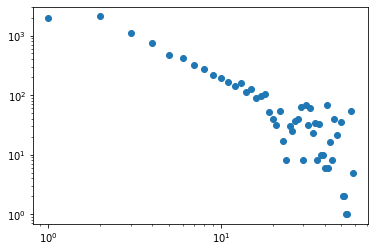

In [23]:
plot_degree_dist(inet_graph)

## Exercice 1: generation

### Question 1

Create a Configuration Model of the graph with the same degree sequence as the original graph.

Unfortunately, the version "with rejection" runs too slowly to be used here, so implement the version "with loops and multi-edges deletion" seen in the course.

In [70]:
def swap(l, i, j):
    l[i], l[j] = l[j], l[i]
def configuration(original_graph):
    my_table = []
    graph = {}
    for node in original_graph:
        my_table += [node] * len(original_graph[node])
        graph[node] = []
    i = len(my_table)
    while i > 0:
        node1_index, node2_index = random.randint(0, i - 1), random.randint(0, i - 2)        
        swap(my_table, node1_index, i - 1)
        swap(my_table, node1_index, i - 2)
        node1, node2 = my_table[i - 1], my_table[i - 2]

        if node1 != node2 and node2 not in graph[node1]:
            graph[node1].append(node2)
            graph[node2].append(node1)
        i = i - 2
        
    return graph
        

        

In [71]:
config_graph = configuration(inet_graph)
print(count_links(config_graph))

35447


### Question 2

* Compare the initial degree distribution to the configuration model degree distribution. To do so, compute the fraction of nodes which degree is different to the orginal distribution: $ \frac{n_{mod}}{n} $.
* Compare the number of triangles of the configuration model to the one of the original graph, explain in one sentence what you have observed and if it is consistent with what you expected.

In [72]:
def compute_diff_ratio(graph1, graph2):
    node_diff = 0
    for node in graph1:
        if len(graph1[node]) != len(graph2[node]):
            node_diff += 1
    return node_diff / len(graph1)

0.021252566735112936

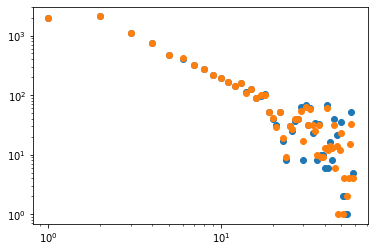

In [73]:
plot_degree_dist(inet_graph)
plot_degree_dist(config_graph)
compute_diff_ratio(inet_graph, config_graph)

## Exercise 2: robustness analysis

### Question 3

In this question, we want to explore if the original network is more or less robust to attacks than the corresponding configuration model is. 

For this purpose, we follow the same protocol as the one we have seen in PW3: we plot the size of the LCC as a function of a number of nodes removed. Nodes are removed randomly.

Discuss your observations in a few sentences, in particular do you think that the degree distribution alone can explain the robustness to random failures?

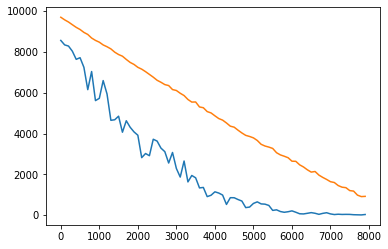

In [75]:
random_inet = random_failure(inet_graph)
random_config = random_failure(config_graph)
x_inet, y_inet = random_inet.keys(), random_inet.values()
x_config, y_config = random_config.keys(), random_config.values()

Text(0, 0.5, 'Size of LCC')

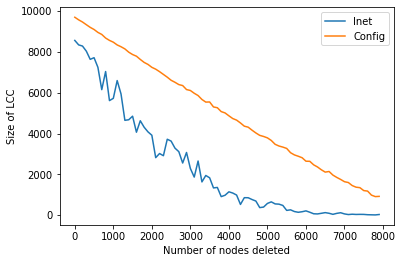

In [107]:
plt.plot(x_inet, y_inet, label = "Inet")
plt.plot(x_config, y_config, label = "Config")
plt.legend()
plt.xlabel("Number of nodes deleted")
plt.ylabel("Size of LCC")

## Exercise 3: basic spreading experiment

In this exercise, we implement a basic SI model on the real network and compare it to the same spreading model on the synthetic graph obtained with the Configuration Model.

In a SI model, a node is either Susceptible (S) or Infected (I) and an Infected node cannot go back to the Susceptible status.

### Question 4

Choose a node which is in the largest connected component (LCC) for both the real graph and the synthetic one. It i named the $seed$ of the infection: it is the only infected node at step = 0.

Then, run the following model: 
- at each step, all infected nodes try to infect all their susceptible neighbors in the graph with a probability $p$ (the same for every node).
- the process stops when every node in the LCC is infected.

**Suggestion**: store the infected nodes in a set, and new infected nodes during one round in another set.

In [95]:
def compute_lcc(graph):
    nodes_cc_index = {}
    cc_index = 0
    cc_dic = []
    for node in graph:
        nodes_cc_index[node] = -1
    for node in graph:
        if nodes_cc_index[node] == -1:
            cc = bfs(graph, node)
            cc_dic.append(cc)
            for node_marked in cc:
                nodes_cc_index[node_marked] = cc_index
            cc_index += 1
    sorted(cc_dic, key=lambda x : len(x), reverse=True)
    return cc_dic[0]
def si_model(graph, p):
    lcc = compute_lcc(graph)
    infected, evolution, step = {lcc[0]}, {0 : 1}, 0
    while len(infected) < len(lcc):
        step += 1
        new_infected = []
        for node1 in infected:
            for node2 in graph[node1]:
                if random.uniform(0,1) < p:
                    new_infected.append(node2)
        infected.update(new_infected)
        evolution[step] = len(infected)
    return evolution
                    
    

In [96]:
inet_evolution = si_model(inet_graph, 0.1)

In [98]:
config_evolution = si_model(config_graph, 0.1)

Plot the number of infected nodes during the spreading process as a function of the number of steps for both the original graph and the synthetic graph. Compare the two curves and explain what you understand from this comparison.

Text(0, 0.5, 'Number of infected')

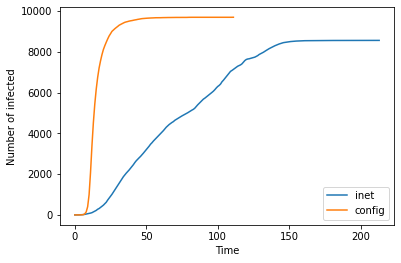

In [105]:
plt.plot(inet_evolution.keys(), inet_evolution.values(), label = "inet")
plt.plot(config_evolution.keys(), config_evolution.values(), label = "config")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number of infected")